In [ ]:
from decision_tree import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
anatel_file_path = '../../data/labeled_csv_files/Anatel_labeled.csv'
anatel = pd.read_csv(anatel_file_path)

### Encoding

In [ ]:
# One-Hot Encoding
anatel = pd.get_dummies(anatel, columns=['Polarization'], prefix='Polarization')
anatel = pd.get_dummies(anatel, columns=['BasicFeatures'], prefix='BasicFeatures')
# Decision trees and random forests can handle boolean variables without encoding. They naturally make binary decisions based on the values of the features.

### Visualizing Correlation

In [ ]:
anatel_numeric = anatel.drop("SiteType", axis=1)
anatel_numeric.corr()

### Removing highly correlated columns

In [ ]:
anatel = anatel.drop(columns = ["Polarization_V", "MinTxFreq", "MaxRxFreq", "BasicFeatures_G7W"])

### Removing columns of too little feature importance

In [15]:
# Must have created the feature_importance variable previously
features_of_little_importance = []
for i, importance in enumerate(feature_importances):
    if importance < 0.01:
        features_of_little_importance.append(feature_names[i])

In [17]:
anatel = anatel.drop(columns = features_of_little_importance)

### Running Decision Tree

In [18]:
# Proportion of the dataset to include in the test split
test_size = 0.2
# Controls the shuffling applied to the data before applying the split (pass int for reproducible output across multiple function 
# calls)
random_state = 42
# The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” 
# both for the Shannon information gain
criterion = 'gini'
# The maximum depth of the tree. i=If None, then nodes are expanded until all leaves are pure or until all leaves contain less than 
# min_samples_split samples
max_depth = None
# The minimum number of samples required to split an internal node
min_samples_split = 2
# The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at 
# least min_samples_leaf training samples in each of the left and right branches.
min_samples_leaf = 1

In [19]:
# Split data into features and target
X = anatel.drop("SiteType", axis=1)
y = anatel["SiteType"]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Build and Train the Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, 
                                    min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
tree_model.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = tree_model.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

In [22]:
cm = confusion_matrix(y_test, y_pred)

In [24]:
feature_importances = tree_model.feature_importances_

In [ ]:
scores = cross_val_score(tree_model, X, y, cv=5)
print("Cross-Validation Scores:", scores)


In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(tree_model, param_grid, cv=5)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


### Visualizing Results

In [21]:
print(f"Accuracy: {accuracy}")

print(F"\nClassification Report: \n {cr}")


Accuracy: 0.8138520269041992

Classification Report: 
               precision    recall  f1-score   support

         COW       0.32      0.32      0.32        28
    FASTSITE       0.67      0.67      0.67         3
  GREENFIELD       0.89      0.88      0.89      8509
 HARMONIZADA       0.30      0.38      0.34        26
      INDOOR       0.85      0.75      0.80       241
     OUTDOOR       0.46      0.33      0.39        33
 RAN SHARING       0.78      0.76      0.77       298
     ROOFTOP       0.49      0.51      0.50      1707
   SMALLCELL       0.87      0.84      0.85        55
 STREETLEVEL       0.60      0.68      0.64       102

    accuracy                           0.81     11002
   macro avg       0.62      0.61      0.62     11002
weighted avg       0.82      0.81      0.82     11002



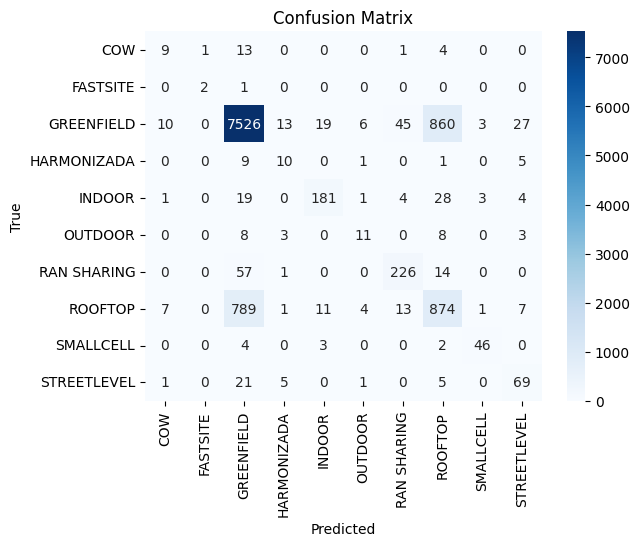

In [23]:
# Confusion Matrix
class_names = tree_model.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
print("Feature Importances:")
feature_names = X.columns
for i, importance in enumerate(feature_importances):
    print(f"{feature_names[i]}: {importance:.4f}")


Feature Importances:
MaxTxFreq: 0.0960
MinRxFreq: 0.0862
AntennaGain: 0.0847
FrontBackAntennaRation: 0.0329
AnguloMeiaPotenciaAntena_max: 0.0618
ElevationAngle: 0.0579
AntennaHeight: 0.1912
TransmitterPower: 0.0426
NecessaryBandwidth: 0.0310
DaysSinceLicensing: 0.0936
DaysSinceFirstLicensing: 0.1618
DaysUntilExpiration: 0.0492
Polarization_X: 0.0111


In [26]:
feature_importances

array([0.09599526, 0.08619362, 0.08471168, 0.0329369 , 0.06183026,
       0.05788683, 0.19122793, 0.04264413, 0.0309628 , 0.09360476,
       0.1617571 , 0.04918089, 0.01106782])